# 1: Linear Regression

In [34]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

Let's see how faster it is to vectorize code.

In [35]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [36]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]

f'{time.time() - t:.5f} sec'

'0.04704 sec'

In [37]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00028 sec'

## 1.3: The Normal Distribution and Squared Loss

Let's compute the normal distribution.

In [38]:
def normal(x, mu, sigma):
    p = 1/math.sqrt(2 * math.pi*sigma**2)
    return p * np.exp(-0.5 * (x-mu) ** 2 / sigma ** 2)

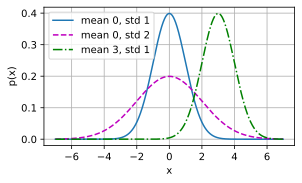

In [39]:
x = np.arange(-7, 7, 0.01)

#Let's compute the Normal for some values of the parameters
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params],
         xlabel="x",
         ylabel="p(x)",
         figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# 2: Object-Oriented Design for Implementation

## 2.1

In [40]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### Add to class method

This is useful for creating methods in a class after it has been created or even instanciated.

In [41]:
def add_to_class(Class):    #@save
    """Register functions as methods in the created class"""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

An example of use:

In [42]:
class A:
    def __init__(self):
        self.b = 1

a = A()

In [43]:
@add_to_class(A)
def do (self):
    print("Class attribute 'b' is", self.b)

a.do()

Class attribute 'b' is 1


### Hyperparameters method

This method, instead, saves all arguments in initialization as *class* attributes, without additional code.

In [44]:
class HyperParameters:  #@save
    """The base class of hyperparameters"""
    def save_hyperparameters(self, ignore = []):
        raise NotImplemented

We can avoid seeing now the real implementation, let's use the method in the package `d2l` instead:

In [45]:
class B(d2l.HyperParameters):
    def __init__(self, a, b, c) -> None:
        self.save_hyperparameters(ignore=["c"])
        print("self.a=", self.a, "self.b=", self.b)
        print("There is no self.c=", not hasattr(self, "c"))

b = B(a=1, b=2, c=3)

self.a= 1 self.b= 2
There is no self.c= True


### Progressboard

It is used to plot experiments interactively while they are ongoing.

In [46]:
class ProgressBoard(d2l.HyperParameters):   #@save
    """The board data plots data points in animation"""
    def __init__(self, xlabel=None, ylabel=None,
                 xlim=None, ylim=None, xscale="Linear", yscale="Linear",
                 ls=["-", "--", "-.", ":"], colors=["C0", "C1", "C2", "C3"],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

The implementation will be explored later, let's use the one in the d2l package.

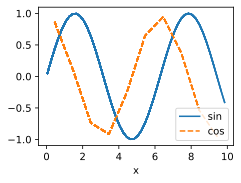

In [47]:
board = d2l.ProgressBoard("x")
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), "sin", every_n=2)
    board.draw(x, np.cos(x), "cos", every_n=10)

## 2.2: Models

The core methods are:
* `__init__` for storing the parameters
* `training_step` for accepting a data batch
* `configure_optimizers`
* `validation_step` for updating the learnable parameters.

In [48]:
class Module(nn.Module, d2l.HyperParameters):   #@save
    """The base class of models"""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError
    
    def forward(self, X):
        assert hasattr(self, "net"), "Neural network is defined"
        return self.net(X)
    
    def plot(self, key, value, train):
        """Plot a point in animation"""

        assert hasattr(self, "trainer"), "Trainer is not initiated"
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            '''
            Note: backward slash means newline. Forward slash is the usual division. 
            '''
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
            
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
            
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
        
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

## 2.3: Data

The core methods are:
* `__init__` is used to prepare data (downloading, preprocessing)
* `train_dataloader` (a dataloader yields a batch each time it is used)
* `val_dataloader`

In [49]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class for data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError
    
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    
    def val_dataloder(self):
        return self.get_dataloader(train=False)

## 2.4: Training

The core methods are:
* `fit`, taking an instance of `Module` and one of `DataModule`

In [50]:
class Trainer(d2l.HyperParameters):     #@save
    '''The base class for training models with data.'''
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_var=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'
    
    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)
        
    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

# 3: Synthetic Regression Data

## 3.1: Generating the dataset

In [51]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

Let's generate a $X \in \mathbb{R}^{1000\times 2}$, with each example drawn from   
$$\mathbf{y} = \mathbf{Xw} + b + \mathbf{\epsilon}$$  
with $\epsilon_i \sim \mathcal{N}(0, 0.01)$

The synthetic dataset code is added to an `__init__` method of a subclass of `d2l`.

In [52]:
class SyntheticRegressionData(d2l.DataModule):      #@save
    """Synthetic data for linear regression"""
    def __init__(self, w, b, noise = 0.01, num_train = 1000, num_val=1000,
                 batch_size = 32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self. y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

Let's set some true parameters. They are also called *ground truth* values, against which we have to check our estimations.

In [53]:
data = SyntheticRegressionData(w = torch.tensor([2, -3.4]), b=4.2)
print('features:', data.X[0], '\nlabel:', data.y[0])

features: tensor([0.1543, 0.8791]) 
label: tensor([1.5086])


## 3.2: Reading the Dataset

In [54]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(self.num_train))
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))

    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i:i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

In [55]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


## 3.3: Concise Implementation of the Data Loader

This employs much faster iterators, built for Deep Learning.

In [56]:
@d2l.add_to_class(d2l.DataModule)   #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [57]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [58]:
len(data.train_dataloader())

32

# 4: Linear Regression from Scratch

## Model

In [59]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [60]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [61]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

## Loss function

In [62]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

## Optimization algorithm

In [63]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [64]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

## Training

In each **epoch**, we iterate through the entire dataset, once for each data point.  
In each **iteration**, we compute the gradient descent for each random minibatch. We then update the parameters via the optimization method.

In [65]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

In [66]:
@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

Now we have to build the dataset which the model will be trained on.

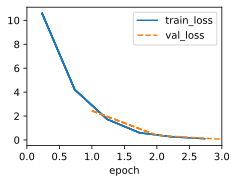

In [68]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [69]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b : {data.b - model.b}')

error in estimating w: tensor([ 0.1425, -0.2252])
error in estimating b : tensor([0.2448])


# 5: Concise implementation for Linear Regression

In [70]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## Model

In PyTorch, **fully connected layers** are defined with *Linear* and *LazyLinear* classes.  
Linear classes require both the input and the output size, with LazyLinear ones require the output only.

In [71]:
class LinearRegression(d2l.Module):     #@save
    """The linear regression model with high-level APIs"""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [72]:
@d2l.add_to_class(LinearRegression)     #@save
def forward(self, X):
    return self.net(X)

## Loss

In [73]:
@d2l.add_to_class(LinearRegression)     #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

## Optimization algorithm

In [74]:
@d2l.add_to_class(LinearRegression)     #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

## Training

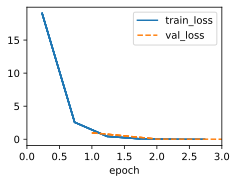

In [76]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)

In [77]:
@d2l.add_to_class(LinearRegression)     #@save

def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0074, -0.0105])
error in estimating b: tensor([0.0174])


## Exercises 

### Ex. 2

In [95]:
class ex1LinearRegression(LinearRegression):
    def loss(self, y_hat, y):
        fn = nn.HuberLoss()
        return fn(y_hat, y)

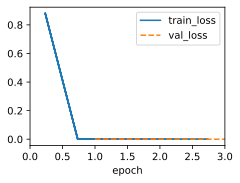

In [102]:
model = ex1LinearRegression(lr=1)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)

### Ex. 3

In [112]:
@d2l.add_to_class(LinearRegression)     #@save
def get_gradients(self):
    return self.net.weights.grad

@d2l.add_to_class(LinearRegression)     #@save
def get_gradients_fn(self):
    return self.net.weights.gradfn

In [116]:
print(f'Gradients are {model.get_gradients}')
print(f'Gradient functions are {model.get_gradients_fn}')

Gradients are <bound method get_gradients of ex1LinearRegression(
  (net): Linear(in_features=2, out_features=1, bias=True)
)>
Gradient functions are <bound method get_gradients_fn of ex1LinearRegression(
  (net): Linear(in_features=2, out_features=1, bias=True)
)>


# 6: Generalization

## Training error and generalization error

We always assume that the training data and the test data are drawn from *independent* and *identical* distributions.  
The *training error* is a statistic calculated on the training dataset.  
The *generalization error* is an expectation taken w.r.t. to the underlying distribution.

In formulas, the training error:
$$R_{emp}[\mathbf{X, y}, f]=\frac{1}{n}\sum_{i=1}^{n}l( \mathbf{x^{(i)}, y^{(i)}}, f(x^{(i)}))$$

While the generalization error:  
$$R[p, f]=E_{(\mathbf{x}, y)\sim P}[\mathbf{x}, y, f(\mathbf{x})]= \int \int l(\mathbf{x}, y, f(x))p(\mathbf{x}, y)d\mathbf{x}dy$$

## Cross-validation

If the data amount is scarce, it might be necessary to split the dataset into *K* non-overlapping sets, and to perform K the training, each time using K-1 different datasets and the remaining one for validation, using the average of the K experiments as a result.